## Includes

In [31]:
from del_tmp_vars import ft_del_tmp_variables
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

g_dataset_name = "BTCUSD_dataset_1H_100candles" # Name of the zip (without .zip) where the data is stored and without _balanced
g_lines_per_file = 16384 # Amount of rows per csv file generated when saving the balanced dataset
g_batch_size = 64 # Amount of rows the model will se before updating its parameters
g_epochs = 250 # Number of times the model will loop through the data
g_learning_rate = 0.001 # Speed at which the model adjusts its parameters
g_split_ratio = 0.8 # Percentage of the whole dataset that goes into train and test (the value is the percentage of train data)
g_dropout_prob = 0.7 # Percentage of neurons ignored in the droupout layers
g_seed=42
g_num_separations_confusion_matrix = 11 # How many different values will be used to round the predictions in the confusion matrix
g_early_stop_epochs = 50 # Number of epochs without the model improving the loss that stop the training (can be None to never stop)
g_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class SimpleModel(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.5):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(512, 64)
        self.dropout2 = nn.Dropout(p=dropout_prob)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.sigmoid(x)
        return x

## Functions

In [13]:
def ft_plot_graphs(train_loss, test_loss, test_accuracy, profit):
    '''
    Plot the training and test losses in one graph, the accuracy in another, and the profit in a third graph.
    '''
    x_axis = range(len(train_loss))

    plt.figure(figsize=(12, 10))

    # Plot Loss
    plt.subplot(3, 1, 1)
    plt.plot(x_axis, train_loss, label='Train Loss')
    plt.plot(x_axis, test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(3, 1, 2)
    plt.plot(x_axis, test_accuracy, label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.ylim(0, 100)
    plt.legend()

    # Plot Profit
    plt.subplot(3, 1, 3)
    plt.plot(x_axis, profit, label='Profit', color='black')
    plt.xlabel('Epochs')
    plt.ylabel('Profit')
    plt.title('Profit')

    # Colorear áreas sobre y bajo cero
    profit = np.array(profit)
    plt.fill_between(x_axis, profit, where=(profit >= 0), interpolate=True, color='green', alpha=0.3)
    plt.fill_between(x_axis, profit, where=(profit < 0), interpolate=True, color='red', alpha=0.3)

    plt.legend()
    plt.tight_layout()
    plt.show()

In [14]:
def ft_plot_confusion_matrix(model, loader,rounding_choices = [0, 1]):
    '''
    Draw a confusion matrix for the model.
    Makes predictions on the loader and outputs the predicted vs true labels.
    '''
    def ft_round_to_nearest(value, choices):
        '''
        Round a value to the nearest choice in a list.
        '''
        return min(choices, key=lambda x: abs(x - value))
    all_labels = []
    all_predictions = []

    # Initialize confusion matrix
    cm = np.zeros((2, len(rounding_choices)), dtype=int)

    # Store expected and model outputs from the dataset
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch).squeeze()
            predictions = outputs.cpu().numpy()  # No sigmoid applied
            rounded_predictions = [ft_round_to_nearest(pred, rounding_choices) for pred in predictions]
            all_labels.extend(y_batch.cpu().numpy())
            all_predictions.extend(rounded_predictions)

    # Ensure both all_labels and all_predictions are numpy arrays
    all_labels = np.array(all_labels, dtype=int)
    all_predictions = np.array(all_predictions, dtype=float)  # Use float for compatibility with rounding choices

    # Manually create the confusion matrix
    for true_label, pred_label in zip(all_labels, all_predictions):
        cm[true_label, rounding_choices.index(pred_label)] += 1

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rounding_choices, yticklabels=[0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.title('Confusion Matrix')
    plt.show()



In [15]:
def ft_train_model(model, train_loader, test_loader, loss_function, optimizer, epochs=10, device="cpu"):
    model.to(device)

    # Variables to store the progress of the training
    train_losses = []
    test_losses = []
    test_accuracies = []
    profit_list = []
    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch).squeeze()
            loss = loss_function(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        test_loss = 0.0
        correct = 0
        profit = 0.0
        total_trades = 0
        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                outputs = model(x_batch).squeeze()
                loss = loss_function(outputs, y_batch)
                test_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == y_batch).sum().item()
                profit += sum(0.02 if y_batch[i] == 1 else -0.01 for i in range(len(predicted)) if predicted[i] == 1)
                total_trades += sum(predicted)

        avg_test_loss = test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        accuracy = correct / len(test_loader.dataset) * 100
        test_accuracies.append(accuracy)

        profit = profit / total_trades * 100
        profit_list.append(profit)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%, profit per trade: {profit:.2f}, trades per candle: {total_trades/len(test_loader.dataset) * 100:.2f}%')
    return train_losses, test_losses, test_accuracies, profit_list

In [16]:
def ft_balance_dataset(df, seed=42):
    # Asegurarse de que la última columna sea la columna objetivo
    target_col = df.columns[-1]

    # Contar el número de muestras en cada clase
    class_counts = df[target_col].value_counts()
    minority_class = class_counts.idxmin()
    minority_count = class_counts.min()

    # Submuestrear la clase mayoritaria
    df_majority_downsampled = df[df[target_col] != minority_class].sample(n=minority_count, random_state=seed)

    # Mantener todas las muestras de la clase minoritaria
    df_minority = df[df[target_col] == minority_class]

    # Combinar los DataFrames submuestreados y minoritarios
    df_balanced = pd.concat([df_majority_downsampled, df_minority])

    # Mezclar el dataset balanceado
    df_balanced_shuffled = df_balanced.sample(frac=1, random_state=seed).reset_index(drop=True)

    return df_balanced_shuffled

In [17]:
def ft_plot_predictions_density(model, test_loader):
    all_labels = []
    all_predictions = []

    # Evaluar el modelo y obtener las predicciones del conjunto de prueba
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            outputs = model(x_batch).squeeze()
            predictions = outputs
            all_labels.extend(y_batch.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    # Convertir listas a arrays de numpy
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)

    # Crear un DataFrame para visualización con seaborn
    df = pd.DataFrame({
        'Labels': all_labels,
        'Predictions': all_predictions
    })

    # Calcular la varianza de las predicciones
    predictions_variance = np.var(df['Predictions'])
    print(f'Variance of Predictions: {predictions_variance}')

    # Graficar el gráfico de densidad si la varianza es mayor que cero
    plt.figure(figsize=(10, 6))
    if predictions_variance > 0:
        sns.kdeplot(df['Predictions'], fill=True)
        plt.axvline(0.5, color='red', linestyle='--')  # Agregar línea vertical en 0.5
        plt.xlabel('Predicted Values')
        plt.ylabel('Density')
        plt.title('Density Plot of Predicted Values')
        plt.show()
    else:
        print("Predictions have zero variance. Consider using a different plot type.")

In [18]:
def ft_save_dataset(df, filename, file_len):
    # Remove '.csv' extension from filename if it exists
    if filename.endswith('.csv'):
        filename = filename[:-4]

    # Create folder if it doesn't exist, or clean it if it does
    if os.path.exists(filename):
        # Remove all contents of the directory
        shutil.rmtree(filename)
    os.makedirs(filename)

    # Save the DataFrame in chunks of file_len rows
    num_slices = df.shape[0] // file_len + (1 if df.shape[0] % file_len != 0 else 0)
    for i in range(num_slices):
        df_slice = df[i*file_len:(i+1)*file_len]
        df_slice.to_csv(f'{filename}/{filename}_{i}.csv', index=False)
    # Download to PCÇ
    zipname = f"{filename}.zip"
    !zip -r {zipname} {filename}

In [19]:
def ft_load_dataset(dataset_name):
    # Extract and get the filenames of the dataset
    if not os.path.exists(dataset_name):
        print(f'Dataset {dataset_name} not found. Downloading...')
        os.system(f'unzip -q {dataset_name}.zip')
        print(f'Dataset {dataset_name} downloaded.')
    else:
        print(f'Dataset {dataset_name} found. Loading...')
    files = os.listdir(dataset_name)
    files.sort()
    files = [os.path.join(dataset_name, file) for file in files]

    df = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    return df

## Code

In [20]:
# Try to load directly the balanced dataset
if os.path.exists(f'{g_dataset_name}_balanced') or os.path.exists(f'{g_dataset_name}_balanced.zip'):
	g_df = ft_load_dataset(f'{g_dataset_name}_balanced')
# If the balanced dataset is not found, try to load the unbalanced dataset and save the balanced version
else:
	print(f'Dataset {g_dataset_name}_balanced<.zip> not found. Trying {g_dataset_name}<.zip>.')
	g_df = ft_balance_dataset(ft_load_dataset(g_dataset_name), seed=g_seed)
	ft_save_dataset(g_df, f'{g_dataset_name}_balanced', g_lines_per_file)

Dataset BTCUSD_dataset_1H_100candles_balanced found. Loading...


In [21]:
## Split between input (X) and output (y)
tmp_X = g_df.iloc[:, :-1].values
tmp_y = g_df.iloc[:, -1].values
## Split in train and test
tmp_X_train, tmp_X_test, tmp_y_train, tmp_y_test = train_test_split(
    tmp_X,
    tmp_y,
    test_size=(1 - g_split_ratio),
    random_state=g_seed)
# Convert to tensor and move to device
tmp_X_train_tensor = torch.tensor(tmp_X_train, dtype=torch.float32).to(g_device)
tmp_y_train_tensor = torch.tensor(tmp_y_train, dtype=torch.float32).to(g_device)
tmp_X_test_tensor = torch.tensor(tmp_X_test, dtype=torch.float32).to(g_device)
tmp_y_test_tensor = torch.tensor(tmp_y_test, dtype=torch.float32).to(g_device)
# Create TensorDataset
tmp_train_dataset = TensorDataset(tmp_X_train_tensor, tmp_y_train_tensor)
tmp_test_dataset = TensorDataset(tmp_X_test_tensor, tmp_y_test_tensor)
# Create Dataloaders
g_train_loader = DataLoader(tmp_train_dataset, batch_size=g_batch_size, shuffle=True)
g_test_loader = DataLoader(tmp_test_dataset, batch_size=g_batch_size, shuffle=False)

ft_del_tmp_variables()

Train dataset size: 30107
Test dataset size: 7527
Number of train batches: 941
Number of test batches: 236
Batch size: 32


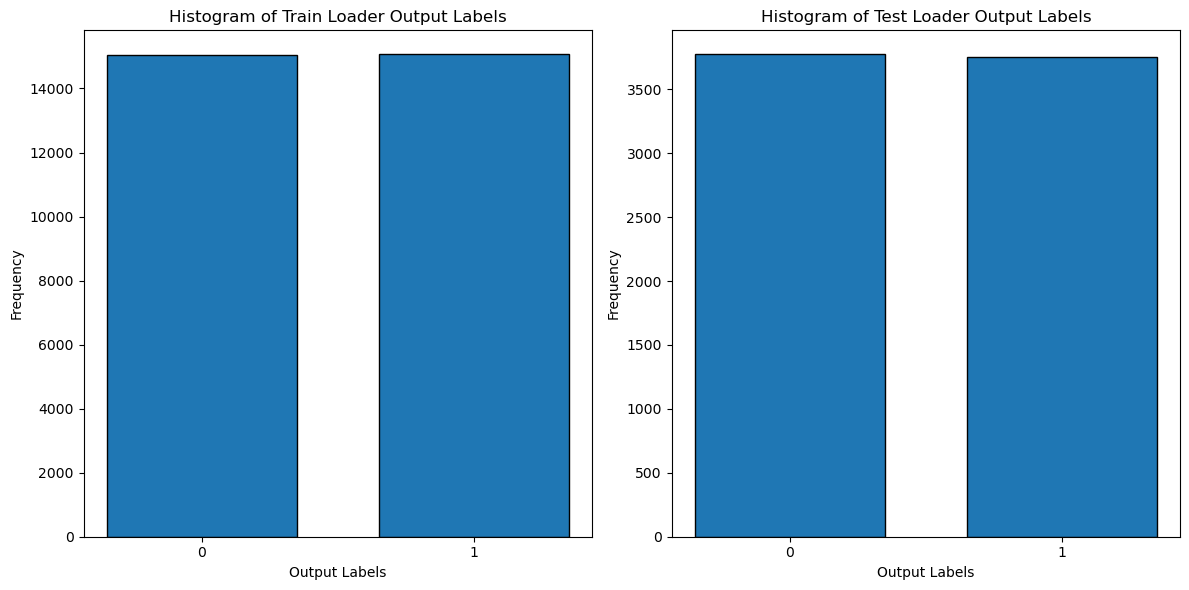

Ratio of 1s to 0s in train_loader: 1.00:1
Ratio of 1s to 0s in test_loader: 0.99:1


In [22]:
# Obtener el tamaño del dataset y número de batches
tmp_train_dataset_size = len(g_train_loader.dataset)
tmp_test_dataset_size = len(g_test_loader.dataset)
tmp_train_batches = len(g_train_loader)
tmp_test_batches = len(g_test_loader)

print(f'Train dataset size: {tmp_train_dataset_size}')
print(f'Test dataset size: {tmp_test_dataset_size}')
print(f'Number of train batches: {tmp_train_batches}')
print(f'Number of test batches: {tmp_test_batches}')
print(f'Batch size: {g_train_loader.batch_size}')

# Crear histograma de las etiquetas en el DataLoader de entrenamiento
tmp_train_labels = []
for _, labels in g_train_loader:
    tmp_train_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(tmp_train_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.7)
plt.xticks([0, 1])
plt.xlabel('Output Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Train Loader Output Labels')

# Crear histograma de las etiquetas en el DataLoader de prueba
tmp_test_labels = []
for _, labels in g_test_loader:
    tmp_test_labels.extend(labels.cpu().numpy())

plt.subplot(1, 2, 2)
plt.hist(tmp_test_labels, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.7)
plt.xticks([0, 1])
plt.xlabel('Output Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Test Loader Output Labels')

plt.tight_layout()
plt.show()

# Calcular y printear el ratio de etiquetas 1 y 0 en train_loader y test_loader
tmp_train_ratio = sum(tmp_train_labels) / (len(tmp_train_labels) - sum(tmp_train_labels))
tmp_test_ratio = sum(tmp_test_labels) / (len(tmp_test_labels) - sum(tmp_test_labels))

print(f'Ratio of 1s to 0s in train_loader: {tmp_train_ratio:.2f}:1')
print(f'Ratio of 1s to 0s in test_loader: {tmp_test_ratio:.2f}:1')

ft_del_tmp_variables()

epoch 25/250, train_loss: 0.6902, test_loss: 0.6883, accuracy: 54.2846%, profit per trade: 0.6729%
epoch 50/250, train_loss: 0.6895, test_loss: 0.6877, accuracy: 53.7266%, profit per trade: 0.5755%
epoch 75/250, train_loss: 0.6880, test_loss: 0.6872, accuracy: 55.0153%, profit per trade: 0.6341%
epoch 100/250, train_loss: 0.6875, test_loss: 0.6870, accuracy: 54.9090%, profit per trade: 0.6343%
epoch 125/250, train_loss: 0.6875, test_loss: 0.6880, accuracy: 54.1783%, profit per trade: 0.7464%
epoch 150/250, train_loss: 0.6867, test_loss: 0.6879, accuracy: 53.7399%, profit per trade: 0.7259%
epoch 175/250, train_loss: 0.6868, test_loss: 0.6870, accuracy: 54.9754%, profit per trade: 0.6274%
epoch 200/250, train_loss: 0.6866, test_loss: 0.6869, accuracy: 54.9754%, profit per trade: 0.6957%
epoch 225/250, train_loss: 0.6869, test_loss: 0.6865, accuracy: 54.6964%, profit per trade: 0.6255%
epoch 238/250, train_loss: 0.6863, test_loss: 0.6880, accuracy: 54.5237%, profit per trade: 0.7285%
Ear

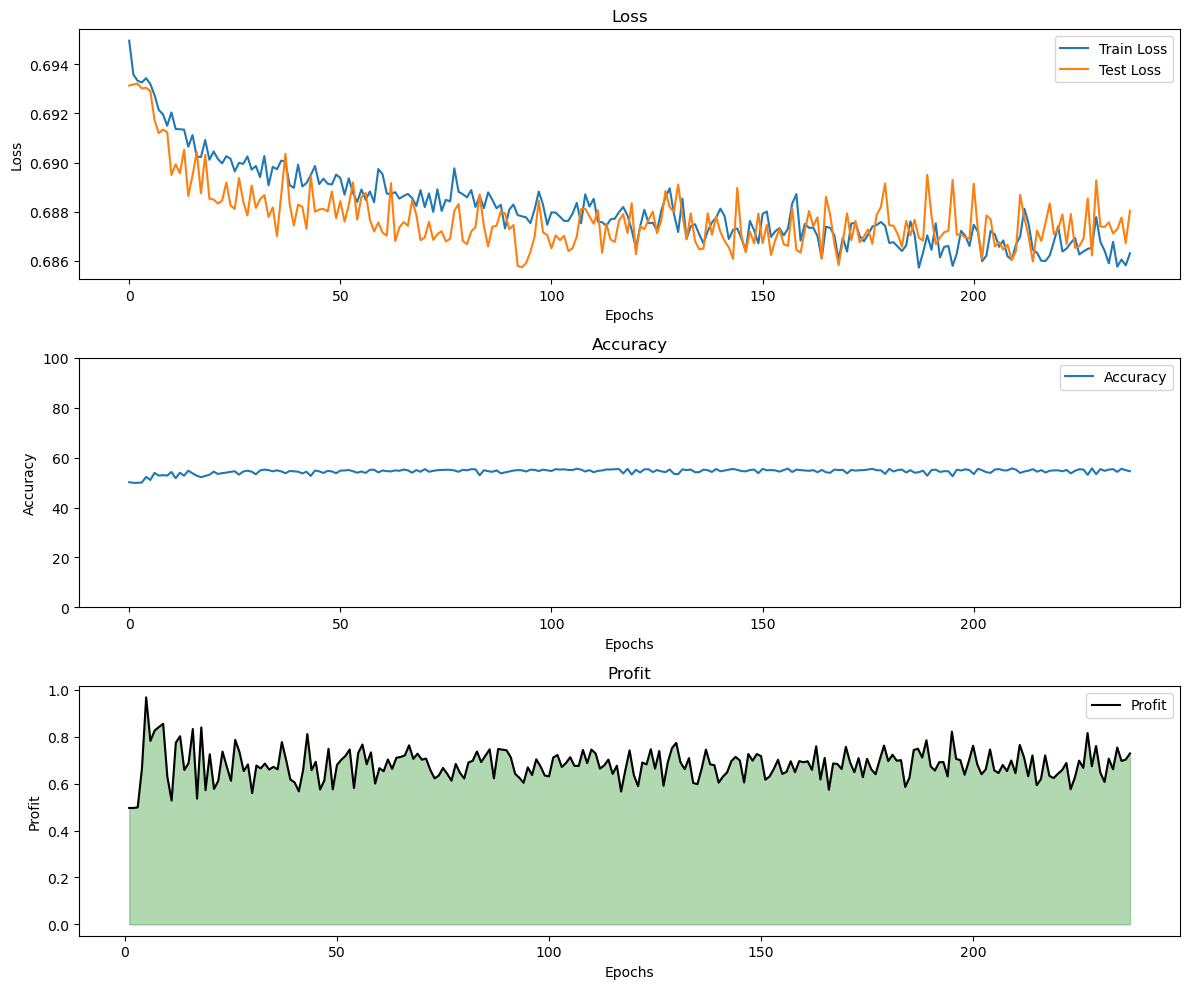

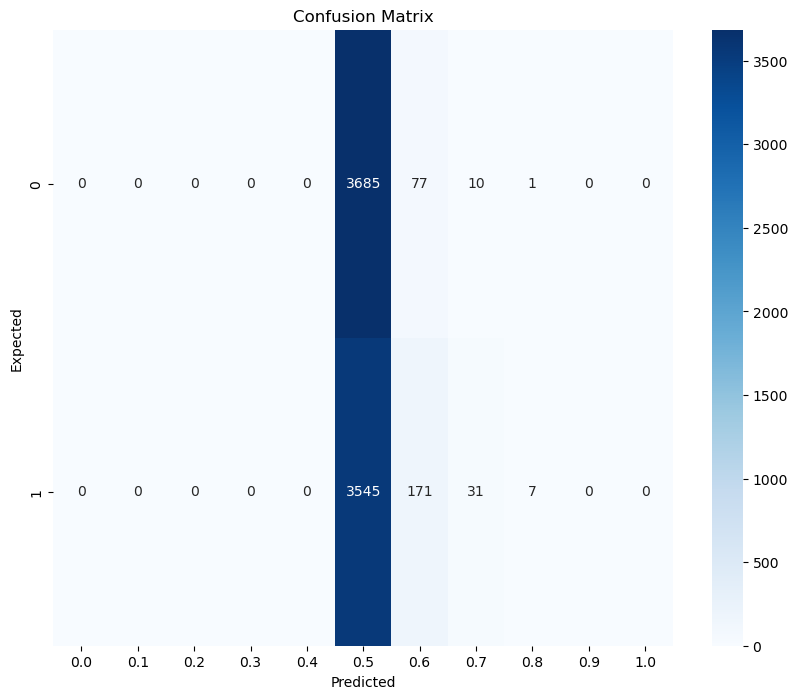

Variance of Predictions: 0.0009270072914659977


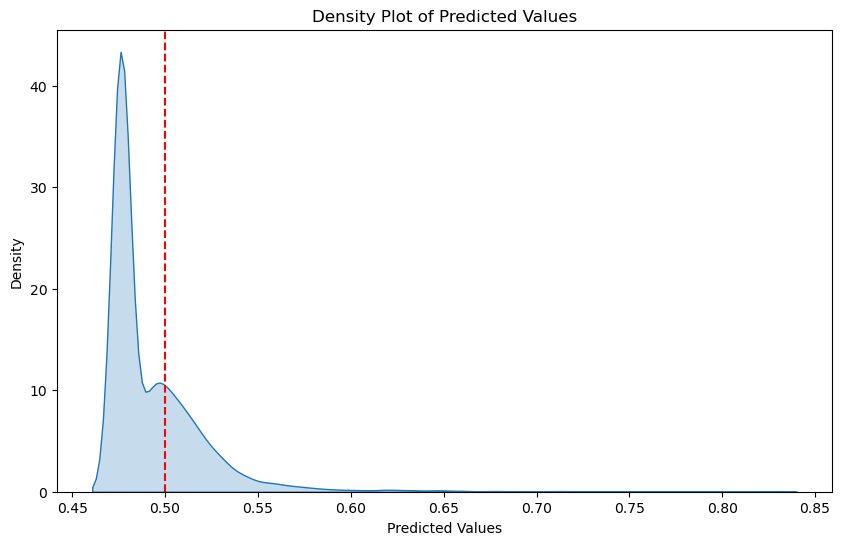

In [32]:
g_model = SimpleModel(len(g_df.columns) - 1).to(g_device)
g_loss_function= nn.BCELoss()
g_optimizer = optim.Adam(g_model.parameters(), lr=g_learning_rate)

#Train the model
tmp_min_loss = float('inf')
g_train_losses, g_test_losses, g_test_accuracies, g_profits = [], [], [], []
for i in range(g_epochs):
    tmp_trainL, tmp_testL, tmp_acc, tmp_profit = ft_train_model(
        g_model,
        g_train_loader,
        g_test_loader,
        g_loss_function,
        g_optimizer,
        epochs=1,
        device=g_device
    )
    # Add results to lists
    g_train_losses.extend(tmp_trainL)
    g_test_losses.extend(tmp_testL)
    g_test_accuracies.extend(tmp_acc)
    g_profits.extend(tmp_profit)
    # Check if loss has improved
    flag = 0
    if g_early_stop_epochs is not None and len(g_train_losses) >= g_early_stop_epochs:
        tmp_recent_losses = g_train_losses[-g_early_stop_epochs:]
        if all(loss > tmp_min_loss for loss in tmp_recent_losses):
            flag = 1
        tmp_new_min = min(tmp_recent_losses)
        if tmp_new_min < tmp_min_loss:
            tmp_min_loss = tmp_new_min
    # plot stuff
    if (i + 1)  % (g_epochs // 10) == 0 or flag == 1:
        print(f"epoch {i + 1}/{g_epochs}, "
            f"train_loss: {g_train_losses[-1]:.4f}, "
            f"test_loss: {g_test_losses[-1]:.4f}, "
            f"accuracy: {g_test_accuracies[-1]:.4f}%, "
            f"profit per trade: {g_profits[-1]:.4f}%")
    # Early stop
    if flag == 1:
        print(f"Early stop due to no loss improvement in {g_early_stop_epochs} candles")
        break

tmp_model_name = f'{g_dataset_name}_layers_64_32.pth'
torch.save(g_model.state_dict(), tmp_model_name)
ft_plot_graphs(g_train_losses,g_test_losses,g_test_accuracies, g_profits)
ft_plot_confusion_matrix(g_model,g_test_loader,np.around(np.linspace(0, 1, g_num_separations_confusion_matrix), decimals=2).tolist())
ft_plot_predictions_density(g_model, g_test_loader)

ft_del_tmp_variables()

### Check with the unbalanced dataset to see how it performs

Dataset BTCUSD_dataset_1H_100candles found. Loading...
Test dataset length (51691,)


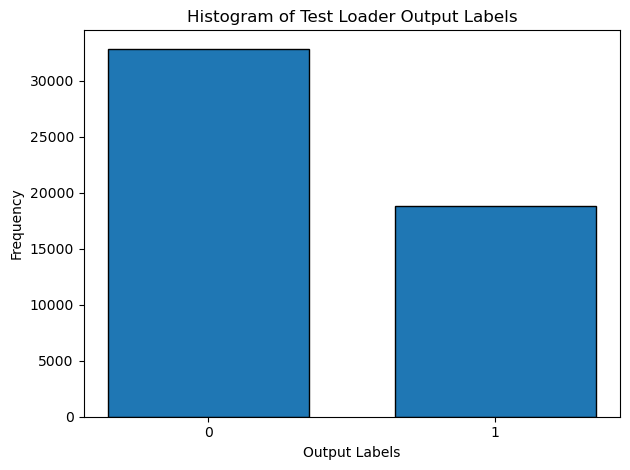

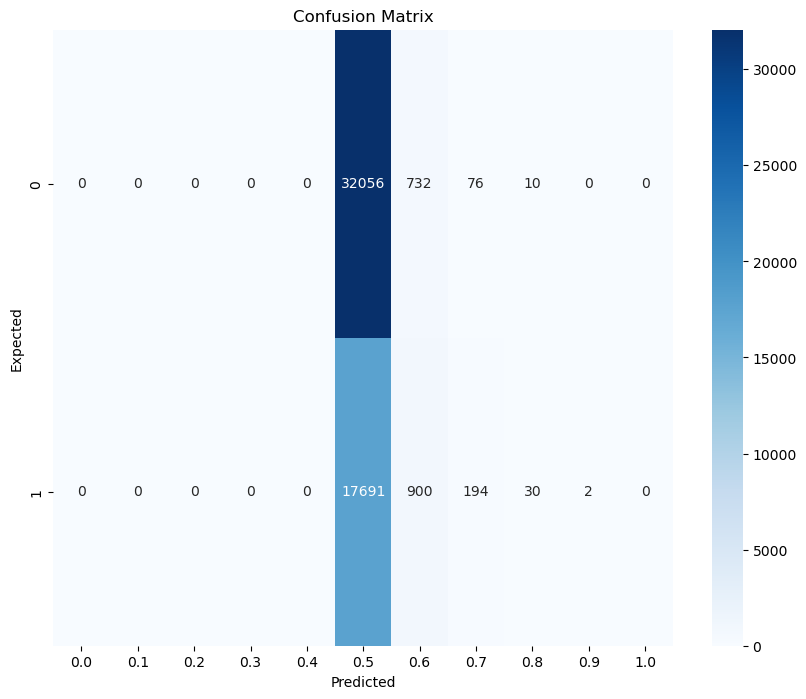

Variance of Predictions: 0.0008689745445735753


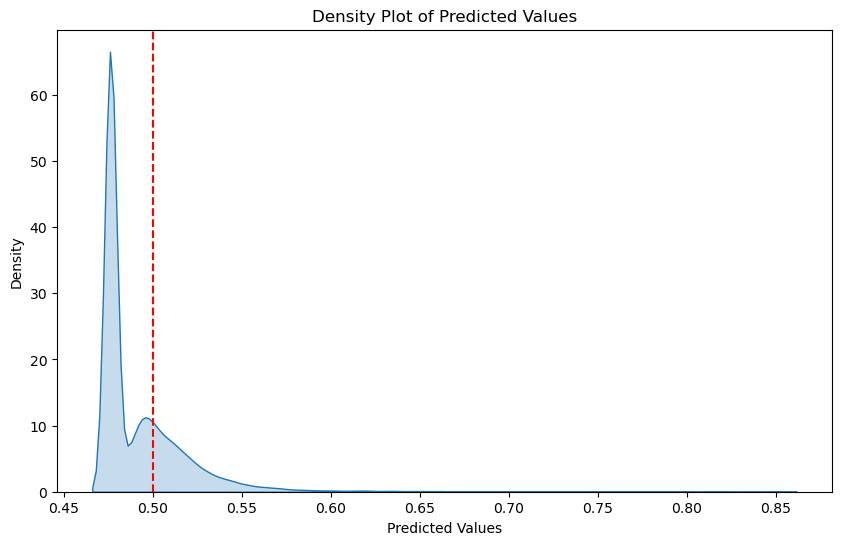

Average profit per trade: 0.3518858551979065%


: 

In [33]:
## Split between input (X) and output (y)
tmp_unbalanced_df = ft_load_dataset(f'{g_dataset_name}')
try:
	g_model;
except:
	if not os.path.exists(f'{g_dataset_name}_model_checkpoints'):
		os.system(f'unzip -q {g_dataset_name}_model_checkpoints.zip')

	g_model = SimpleModel(len(tmp_unbalanced_df.columns) - 1).to(g_device)
	files = os.listdir(f'{g_dataset_name}_model_checkpoints')
	files.sort()
	files = [os.path.join(f'{g_dataset_name}_model_checkpoints', file) for file in files]
	g_model.load_state_dict(torch.load(files[len(files)-1]))


tmp_X = tmp_unbalanced_df.iloc[:, :-1].values
tmp_y = tmp_unbalanced_df.iloc[:, -1].values
print(f'Test dataset length {tmp_y.shape}')
# Convert to tensor and move to device
tmp_X_test_tensor = torch.tensor(tmp_X, dtype=torch.float32).to(g_device)
tmp_y_test_tensor = torch.tensor(tmp_y, dtype=torch.float32).to(g_device)
# Create TensorDataset
tmp_test_dataset = TensorDataset(tmp_X_test_tensor, tmp_y_test_tensor)
# Create Dataloaders
tmp_test_loader = DataLoader(tmp_test_dataset, batch_size=g_batch_size, shuffle=False)
# Crear histograma de las etiquetas en el DataLoader de prueba

plt.hist(tmp_y, bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.7)
plt.xticks([0, 1])
plt.xlabel('Output Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Test Loader Output Labels')

plt.tight_layout()
plt.show()
ft_plot_confusion_matrix(g_model,tmp_test_loader,np.around(np.linspace(0, 1, g_num_separations_confusion_matrix), decimals=2).tolist())
ft_plot_predictions_density(g_model, tmp_test_loader)
# Calculate profit per trade
g_model.eval()
tmp_profit = 0.0
tmp_total_trades = 0
with torch.no_grad():
	for x_batch, y_batch in tmp_test_loader:
		tmp_predicted = (g_model(x_batch).squeeze() > 0.5).float()
		tmp_profit += sum(0.02 if y_batch[i] == 1 else -0.01 for i in range(len(tmp_predicted)) if tmp_predicted[i] == 1)
		tmp_total_trades += sum(tmp_predicted)

print(f'Average profit per trade: {tmp_profit / tmp_total_trades * 100}%')

ft_del_tmp_variables()